<a href="https://colab.research.google.com/github/matibag1714977/LabiagiProject/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Progetto-Scene Classification**

Import

In [122]:
import numpy as np      #to perform mathematical operations on arrays and matrices
import matplotlib.pyplot as plt  #to visualize images and plot graphs

#provides algoithms and tools for data analysis and modeling(classification,regression,clustering)
from sklearn.model_selection import train_test_split        
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

#It provides a user-friendly interface for building and training deep learning models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.applications.resnet50 import ResNet50

# It provides various tools and functions for image and video processing, including image filtering, feature detection, and object tracking.
import cv2
import imghdr
import os

import torch
import torchvision
import torchvision.transforms as transforms

import splitfolders



ModuleNotFoundError: ignored

#Import dataset Prova

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

folder_id = '1pFM_HpOjh0qbAadk0-1Fz89mwLHrnQHB?usp=share_link'
data_path = '/content/gdrive/MyDrive/Dataset/input_data'


# mount the folder
drive.mount('/content/gdrive', force_remount=True)




Mounted at /content/gdrive
Mounted at /content/gdrive


#Dividere tramite Pytorch

In [144]:
import os
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# Definisci la trasformazione delle immagini
transform = transforms.Compose(
    [transforms.Resize((256, 256)),transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
input_path='/content/gdrive/MyDrive/Dataset/input_data'
# Carica il dataset
dataset = datasets.ImageFolder(input_path, transform=transform)

print(dataset)

# Definisci le proporzioni di training, validation e test set
train_ratio = 0.9
val_ratio = 0.10
#test_ratio = 0.20

b_size=4

# Calcola le lunghezze dei subset
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Dividi il dataset in training, validation e test set
#train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_split=data.random_split(dataset, [train_size, len(dataset)-train_size])[0]
train_loader=data.DataLoader(train_split,batch_size=b_size, shuffle=True, num_workers=2)

validation_split=data.random_split(dataset, [val_size, len(dataset)-val_size])[0]
validation_loader=data.DataLoader(validation_split,batch_size=b_size, shuffle=True,  num_workers=2)

print(train_size)






Dataset ImageFolder
    Number of datapoints: 6660
    Root location: /content/gdrive/MyDrive/Dataset/input_data
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
5994


In [140]:
import torch.optim as optim
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model

device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")


# Definire i parametri di addestramento
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Costruire la rete ResNet50
model = resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [145]:

num_epochs=10

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

KeyboardInterrupt: ignored

In [120]:
import gc
total_step = len(train_loader)
num_epochs=10

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(val_size, 100 * correct / total)) 

KeyboardInterrupt: ignored

In [82]:
def train(epoch, log_interval=100):
  model.train()
  for batch_idx, (data,labels) in enumerate(train_loader):
    data=data.to(device)
    optimizer.zero_grad()

    L,target_ab = batchLab2L_ab(data)
    L = L.to(device)
    target_ab=target_ab.to(device)

    inferred_ab=target_ab.to(device)
    loss=criterion(inferred_ab, target_ab)

In [137]:
import torch.optim as optim

# Definire i parametri di addestramento
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Costruire la rete ResNet50
model = resnet50(pretrained=False)
num_classes = 10
model.fc = nn.Linear(2048, num_classes) # Modificare l'ultimo strato per adattarsi al numero di classi
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [25]:
num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Zero grad
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass e aggiornamento dei pesi
        loss.backward()
        optimizer.step()
    
    # Valuta il modello sul dataset di test
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print('Accuracy of the model on the test images: {:.2f}%'.format(accuracy))

KeyboardInterrupt: ignored

Mostra alcune immagini

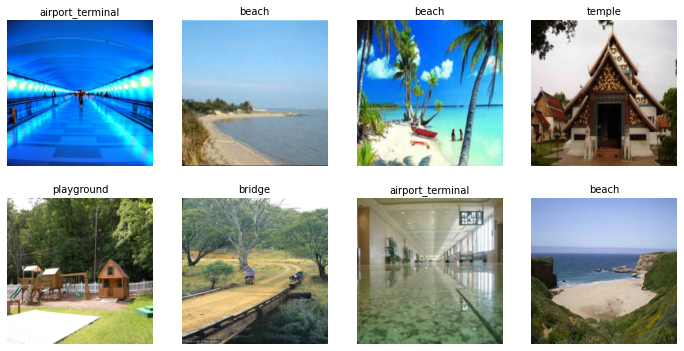

In [104]:
import random
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

# Target image size
image_size = (224, 224)

# Path to the main SUN397 dataset directory
dataset_path = "/content/gdrive/MyDrive/Dataset/input_data"

# Transformation pipeline to preprocess the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the ImageFolder dataset
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)

# List of the 10 classes to display
classes_to_display = ["beach", "temple", "forest", "mountain", "airport_terminal", "river", "street", "playground", "skyscraper","bridge"]

# Select 8 random images from the dataset
random_images = random.sample(dataset.imgs, 8)

# Plot the selected images along with their class name
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    img_path, label = random_images[i]
    class_name = dataset.classes[label]
    if class_name in classes_to_display:
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        img = img.permute(1, 2, 0).numpy() # Convert from Tensor to numpy array and permute dimensions
        img = (img * 0.5) + 0.5 # Reverse the normalization
        img = Image.fromarray((img * 255).astype('uint8')) # Convert from numpy array to PIL Image
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(class_name, fontsize=10)

plt.show()
